# Project Overview

In this project we will perform exploratory data analysis to provide feedback to a stakeholder.
Data visualization will be used as a tool to deliver our recommendation.

# Business Problem

Microsoft is considering to expand its business into creating video content for entertainment industry. They need guidance for creating these contents.  The objective of this project is to provide Microsoft data driven feedback for creating successful content with optimum return on investment.

## Master Data Set
The master data set is split into two. The first is used for analysis of ROI in different genre and movie rating indicators. This consists of the following available databases:
* MovieBasics from IMDB database
* MovieRatings from IMDB database
* The Numbers database
* The Movie database

The second is used for analysis of ROI to movie people and this consists of:
* The Numbers database
* Directors from IMDB database
* Writers from IMDB database
* Known_for from IMDB database

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import scipy.stats as stats
import sqlite3
from matplotlib.colors import ListedColormap
from import_and_clean_data import generatePeopleDF

%matplotlib inline

## Reading data files and merge data

The database files are read into Pandas dataframes. The dataframes are merged into in single
dataframe.

In [2]:
# Read relevant tables into pandas dataframe
# IMDB database
# ***IMPORTANT*** Make sure to unzip the "im.db.zip" file into "im.db"
con = sqlite3.connect('../data/im.db') 
cursor = con.cursor()
imdb_schema_df = pd.read_sql('''
SELECT 
    *
FROM
    sqlite_master
''', con)

In [3]:
movie_basics_df = pd.read_sql('''
SELECT 
    *
FROM
    movie_basics
''', con)

In [4]:
movie_ratings_df = pd.read_sql('''
SELECT 
    *
FROM
    movie_ratings
''', con)

In [5]:
# The Numbers movie information table
tn_movies_df = pd.read_csv('../data/tn.movie_budgets.csv.gz')

In [6]:
# TheMovieDB movie information table
tmdb_movies_df = pd.read_csv('../data/tmdb.movies.csv.gz')

In [7]:
# # Merge the following pandas dataframes together
#   1. movie_basics_df (from IMDB database)
#   2. movie_ratings_df (from IMDB database)
#   3. tn_movies_df (from The Numbers database)
#   4. tmdb_movies_df (from The Movie database)

movie_basics_ratings_df = pd.read_sql('''
SELECT
    *
FROM 
    movie_basics
    LEFT JOIN movie_ratings
        ON movie_basics.movie_id = movie_ratings.movie_id
''', con)

In [8]:
movie_basics_ratings_tmdb_df = movie_basics_ratings_df.merge(tmdb_movies_df,
                                                             left_on='primary_title',
                                                             right_on='title',
                                                             how='inner')

In [9]:
movie_basics_ratings_tmdb_tn_df = movie_basics_ratings_tmdb_df.merge(tn_movies_df,
                                                                     left_on='title',
                                                                     right_on='movie',
                                                                     how='inner')

In [10]:
# Generate DataFrame for movie people  
df = generatePeopleDF('../data/tn.movie_budgets.csv.gz', '../data/im.db')
df

C:\Users\nicho\.conda\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


primary_name  \
directors 0               Peter Jackson   
          1                Dean DeBlois   
          2     Rawson Marshall Thurber   
          3              James DeMonaco   
          4          Genndy Tartakovsky   
...                                 ...   
actors    1571       Scarlett Johansson   
          1572           Parisse Boothe   
          1573          Timothy Johnson   
          1574           Jason Cavalier   
          1575               Scott Haze   

                                                       movie_info  num_movies  \
directors 0     [{'primary_title': 'The Hobbit: The Battle of ...           3   
          1     [{'primary_title': 'How to Train Your Dragon: ...           3   
          2     [{'primary_title': 'We're the Millers', 'genre...           3   
          3     [{'primary_title': 'The Purge', 'genres': ['ho...           3   
          4     [{'primary_title': 'Hotel Transylvania', 'genr...           3   
...                                                           ...         ...   
actors    1571  [{'primary_title': 'Her', 'genres': ['drama', ...           4   
          1572  [{'primary_title': 'MacGruber', 'genres': ['ac...           4   
          1573  [{'primary_title': 'Carol', 'genres': ['drama'...           4   
          1574  [{'primary_title': 'Deadfall', 'genres': ['cri...           4   
          1575  [{'primary_title': 'Venom', 'genres': ['action...           4   

                                                           genres  \
directors 0                          [fantasy, family, adventure]   
          1                        [animation, adventure, action]   
          2          [adventure, action, crime, comedy, thriller]   
          3                    [thriller, horror, action, sci-fi]   
          4                [animation, family, adventure, comedy]   
...                                                           ...   
actors    1571  [drama, adventure, action, sci-fi, romance, ho...   
          1572  [adventure, action, crime, sci-fi, romance, co...   
          1573  [drama, adventure, action, sci-fi, romance, th...   
          1574  [drama, adventure, action, crime, sci-fi, roma...   
          1575  [drama, mystery, war, action, sci-fi, thriller...   

                mean_total_gross  median_total_gross  std_total_gross  \
directors 0         1.246479e+09        1.218734e+09     6.431229e+07   
          1         7.280305e+08        7.124522e+08     5.737818e+07   
          2         3.784606e+08        3.725357e+08     3.714348e+07   
          3         1.787981e+08        1.830974e+08     2.123767e+07   
          4         6.201998e+08        6.392004e+08     8.547937e+07   
...                          ...                 ...              ...   
actors    1571      5.741906e+08        7.285145e+07     1.045106e+09   
          1572      5.711876e+08        6.318974e+07     1.046935e+09   
          1573      5.688606e+08        6.376292e+07     1.048603e+09   
          1574      2.564239e+08        2.108569e+07     4.837437e+08   
          1575      2.749402e+08        1.542862e+07     5.281828e+08   

                coefficient_of_variation profession  
directors 0                     0.051595   director  
          1                     0.078813   director  
          2                     0.098144   director  
          3                     0.118780   director  
          4                     0.137826   director  
...                                  ...        ...  
actors    1571                  1.820137      actor  
          1572                  1.832909      actor  
          1573                  1.843339      actor  
          1574                  1.886500      actor  
          1575                  1.921083      actor  

[1980 rows x 9 columns]

## Data cleaning & engineering
Columns not needed for analysis are drooped. Convert 'production_budget', 'domestic_gross', 'worldwide_gross' to integer and 'release_date' to datetime object. Create a new column called 'Assigned_genre_ids' and assign to it the first number of 'genre_ids' and covert this to integer. Drop rows where 'genre_ids' cell is empty and drop rows if production_budget, domestic_gross or worldwide_gross has a value of zero. Remove rows with release date less than 2000. Drop duplicated rows. Drop NaN rows for 'averagerating' column. Create a dictionary called 'genre_ids_dict' with key assocaited with 'Assigned_genre_ids' and values with writtten genre name. Then, create a column called 'Assigned_genre_name' and use the dictionary to input written genre name with the respective key.Two additional columns are created for 'Pofit' and 'ROI' calculation. Create a dataframe called 'genre_ratings_df' by copying 'movie_basics_ratings_tmdb_tn_df' and rearrange columns so related columns placed close to one another.

In [11]:
# Remove columns not needed for analysis
# for column in movie_basics_ratings_tmdb_tn_df.colum
columns_to_drop = ['movie_id','primary_title', 'original_title_x', 'start_year',
       'runtime_minutes', 'movie_id','Unnamed: 0', 'id_x', 'original_language',
        'original_title_y','vote_average','title','id_y','release_date_y']

movie_basics_ratings_tmdb_tn_df.drop(columns = columns_to_drop,inplace=True)

In [12]:
# set movie column as dataframe index
movie_basics_ratings_tmdb_tn_df.set_index('movie',inplace=True)

In [13]:
# Remove any non-digit character from columns production_budget, domestic_gross
# and worldwide_gross and then convert the value for these columns to integer
for column_title in ['production_budget','domestic_gross','worldwide_gross']:
    movie_basics_ratings_tmdb_tn_df[column_title].replace('[^\d]','',inplace=True,regex=True)
    movie_basics_ratings_tmdb_tn_df[column_title] = movie_basics_ratings_tmdb_tn_df[
        column_title].astype(np.int64)

In [14]:
#Change 'release_date_x' to datetime object and change column name to 'release_date'
movie_basics_ratings_tmdb_tn_df['release_date_x'] = pd.to_datetime(
    movie_basics_ratings_tmdb_tn_df['release_date_x'])

movie_basics_ratings_tmdb_tn_df.rename(columns ={'release_date_x' : 'release_date'},
                                      inplace=True)

In [15]:
#Replace from 'genre_ids' column the brackets '[' and ']' surrounding the numbers
movie_basics_ratings_tmdb_tn_df['genre_ids'].replace('[\[\]]','',regex=True,inplace=True)


In [16]:
# Create a new column called 'Assigned_genre_ids' and assign to it the first number 
# from 'genre_ids
movie_basics_ratings_tmdb_tn_df['Assigned_genre_ids'] = movie_basics_ratings_tmdb_tn_df[
    'genre_ids'].map(lambda s: s.split(',')[0])


In [17]:
# Drop rows where 'genre_ids' cell is empty
movie_basics_ratings_tmdb_tn_df.drop(
    movie_basics_ratings_tmdb_tn_df[
        movie_basics_ratings_tmdb_tn_df['genre_ids']== ''].index,inplace=True)

#drop rows if production_budget, domestic_gross or worldwide_gross has a value of zero
movie_basics_ratings_tmdb_tn_df.drop(movie_basics_ratings_tmdb_tn_df[
    (movie_basics_ratings_tmdb_tn_df['production_budget'] == 0) |
                 (movie_basics_ratings_tmdb_tn_df['domestic_gross'] == 0) | 
                 (movie_basics_ratings_tmdb_tn_df[
                     'production_budget'] == 0)].index,inplace=True)

#Remove rows with release date less than 2000
movie_basics_ratings_tmdb_tn_df.drop(movie_basics_ratings_tmdb_tn_df[
    movie_basics_ratings_tmdb_tn_df[
        'release_date'] < pd.to_datetime('2000')].index,inplace=True)

# Change data type for column 'Assigned_genre_ids' to integer
movie_basics_ratings_tmdb_tn_df['Assigned_genre_ids'] = movie_basics_ratings_tmdb_tn_df[
    'Assigned_genre_ids'].astype(int)


In [18]:
# Drop duplicated rows
movie_basics_ratings_tmdb_tn_df.drop_duplicates(inplace=True)


In [19]:
# Drop NaN rows for averagerating
movie_basics_ratings_tmdb_tn_df.dropna(subset=['averagerating'],inplace=True)


In [20]:
# Create a dictionary called 'genre_ids_dict' with key assocaited with 'Assigned_genre_ids'
# and values with writtten genre name  
genre_ids_dict = {
                28 : 'Action', 12 : 'Adventure', 16 : 'Animation', 35 : 'Comedy',
                80 : 'Crime', 99 : 'Documentary', 18: 'Drama', 10751 : 'Family',
                14 : 'Fantasy', 36 : 'History', 27 : 'Horror', 10402 : 'Music',
                9648 : 'Mystery', 10749 : 'Romance', 878 : 'Science Fiction',
                10770 : 'TV Movie', 53 : 'Thriller', 10752 : 'War', 37 : 'Western'}

# Create a column called 'Assigned_genre_name' and use the dictionary called 'genre_ids_dict
# input written genre name with the respective key
movie_basics_ratings_tmdb_tn_df['Assigned_genre_name'] = movie_basics_ratings_tmdb_tn_df[
    'Assigned_genre_ids'].map(lambda n: genre_ids_dict[n])


In [21]:
#creating 'Profit' column
movie_basics_ratings_tmdb_tn_df['Profit'] = movie_basics_ratings_tmdb_tn_df[
    'worldwide_gross'] - movie_basics_ratings_tmdb_tn_df['production_budget'] 

#creating 'ROI' column
movie_basics_ratings_tmdb_tn_df['ROI'] = (movie_basics_ratings_tmdb_tn_df[
    'Profit']) / (movie_basics_ratings_tmdb_tn_df['production_budget'])*100

In [22]:
# Create a dataframe called 'genre_ratings_df' by copying 'movie_basics_ratings_tmdb_tn_df' 
# and rearrange columns so related columns placed close to one another

genre_ratings_df = movie_basics_ratings_tmdb_tn_df[['genres','genre_ids','Assigned_genre_ids',
                                                   'Assigned_genre_name','averagerating',
                                                    'numvotes','popularity','vote_count',
                                                    'release_date','production_budget',
                                                    'domestic_gross','worldwide_gross',
                                                   'Profit','ROI']].copy()

genre_ratings_df

,genres,genre_ids,Assigned_genre_ids,Assigned_genre_name,averagerating,numvotes,popularity,vote_count,release_date,production_budget,domestic_gross,worldwide_gross,Profit,ROI
movie,,,,,,,,,,,,,,
The Overnight,None,"9648, 35",9648,Mystery,7.5,24.0,6.576,200,2015-06-19,200000,1109808,1165996,965996,482.998000
The Overnight,"Comedy,Mystery","9648, 35",9648,Mystery,6.1,14828.0,6.576,200,2015-06-19,200000,1109808,1165996,965996,482.998000
On the Road,"Adventure,Drama,Romance","12, 18",12,Adventure,6.1,37886.0,8.919,518,2012-12-21,25000000,720828,9313302,-15686698,-62.746792
On the Road,Drama,"12, 18",12,Adventure,6.0,6.0,8.919,518,2012-12-21,25000000,720828,9313302,-15686698,-62.746792
On the Road,Drama,"12, 18",12,Adventure,5.7,127.0,8.919,518,2012-12-21,25000000,720828,9313302,-15686698,-62.746792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Paul, Apostle of Christ","Adventure,Biography,Drama",36,36,History,6.7,5662.0,12.005,98,2018-03-28,5000000,17547999,25529498,20529498,410.589960
Instant Family,"Comedy,Drama","35, 18",35,Comedy,7.4,46728.0,22.634,782,2018-11-16,48000000,67363237,119736188,71736188,149.450392
Hereditary,"Drama,Horror,Mystery","27, 9648, 53",27,Horror,7.3,151571.0,26.185,2491,2018-06-08,10000000,44069456,70133905,60133905,601.339050


In [23]:
genre_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2429 entries, The Overnight to Fahrenheit 11/9
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   genres               2417 non-null   object        
 1   genre_ids            2429 non-null   object        
 2   Assigned_genre_ids   2429 non-null   int32         
 3   Assigned_genre_name  2429 non-null   object        
 4   averagerating        2429 non-null   float64       
 5   numvotes             2429 non-null   float64       
 6   popularity           2429 non-null   float64       
 7   vote_count           2429 non-null   int64         
 8   release_date         2429 non-null   datetime64[ns]
 9   production_budget    2429 non-null   int64         
 10  domestic_gross       2429 non-null   int64         
 11  worldwide_gross      2429 non-null   int64         
 12  Profit               2429 non-null   int64         
 13  ROI            

## Data visualization

### The case for targeting world-wide market in order to maximize profit potential

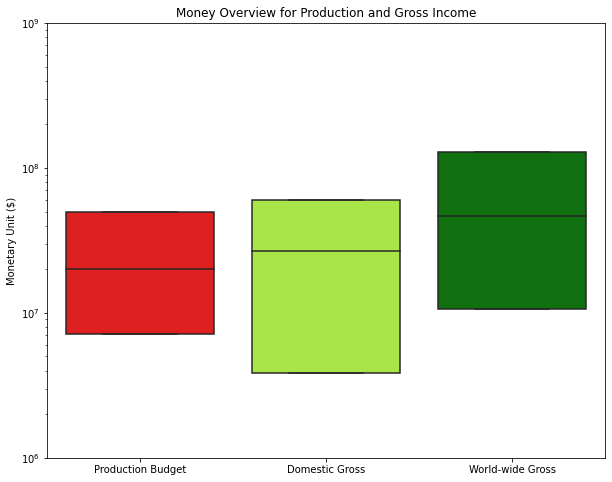

In [24]:

# Create a new dataframe called 'budget_domestic_worldwide_df' from 'genre_ratings_df'
# that has three colulmns for production_budget, domestic_gross and worldwide_gross
budget_domestic_worldwide_df = genre_ratings_df[['production_budget','domestic_gross',
                                                 'worldwide_gross']].copy()


# Make boxplot for production_budget, domestic_gross and worldwide_gross all in one axes
# Remove whiskers and outliers for better visualization
fig = plt.subplots(figsize=(10,8))
colors = ['#FF0000','#ADFF2F','#008000']
money_overview =sns.boxplot(x='variable',y='value',
                            data=pd.melt(budget_domestic_worldwide_df),
                            whis=0,fliersize=0,palette=colors)

money_overview.set_title('Money Overview for Production and Gross Income')
money_overview.set_xlabel('')
money_overview.set_xticklabels(['Production Budget','Domestic Gross','World-wide Gross'])
money_overview.set_ylabel('Monetary Unit ($)')
money_overview.set_yscale('log')
money_overview.set_ylim(10**6,10**9);
plt.savefig('production_gross.jpeg')

### Make the case for Genre vs return on investment (ROI)

In [25]:
#creating ROI df to mess with, without editing genre_ratings df
#genre_roi_df = genre_ratings_df.loc[:, ['Assigned_genre_name', 'ROI', 'Profit',  
#                                        'production_budget', 'domestic_gross', 
#                                        'worldwide_gross','release_date']]

genre_roi_df = genre_ratings_df[['Assigned_genre_name', 'ROI', 'Profit','production_budget',
                                'domestic_gross','worldwide_gross','release_date']].copy()

genre_roi_df.groupby('Assigned_genre_name').agg({'ROI' : 'mean',
                                                 'Profit' : 'mean',
                                                 'production_budget' : 'mean',
                                                 'domestic_gross' : 'mean',
                                                 'worldwide_gross' : 'mean'}).sort_values(
                                                        by='ROI',ascending=False)

# ROI calculation does not make sense

,ROI,Profit,production_budget,domestic_gross,worldwide_gross
Assigned_genre_name,,,,,
Horror,1263.932961,5.410249e+07,1.692325e+07,3.449283e+07,7.102574e+07
Family,1133.643458,2.757546e+08,4.830000e+07,1.373458e+08,3.240546e+08
Fantasy,1031.056122,2.055328e+08,6.630217e+07,1.154035e+08,2.718350e+08
Mystery,649.211272,6.142853e+07,1.994878e+07,3.752834e+07,8.137731e+07
Thriller,545.324753,6.726328e+07,2.603103e+07,3.764339e+07,9.329431e+07
Romance,525.303044,9.168097e+07,2.373630e+07,5.337560e+07,1.154173e+08
Science Fiction,385.684021,1.460176e+08,5.181643e+07,7.457017e+07,1.978341e+08
TV Movie,344.766110,1.723831e+08,5.000000e+07,9.174216e+07,2.223831e+08
Comedy,318.717588,5.218983e+07,2.435129e+07,4.132176e+07,7.654112e+07


In [26]:
genre_ratings_df['Assigned_genre_name'].value_counts()

Drama              679
Comedy             355
Action             334
Horror             183
Thriller           174
Adventure          130
Crime              109
Documentary        102
Romance             73
Animation           64
Science Fiction     63
Fantasy             46
Mystery             41
Family              25
History             19
War                 16
Western              8
Music                7
TV Movie             1
Name: Assigned_genre_name, dtype: int64

In [27]:
# Maybe we should leave genre as they are.  After doing this comedy completely goes away which
# does not make sense
#combing low valued genres to similar genres
genre_mapping = {
    'Action': 'ActAdv',
    'Adventure': 'ActAdv',
    'War':'ActAdv',
    'Western':'ActAdv',
    'Drama' : 'Drama',
    'Thriller': 'Thriller',
    'Mystery': 'Thriller',
    'Horror': 'Horror',
    'Crime' : 'Crime',
    'Romance': 'Romance',
    'Documentary': 'Documentary',
    'History': 'Documentary',
    'Science Fiction': 'SciFan',
    'Fantasy': 'SciFan',
    'Family': 'Family',
    'Animation': 'Family',
    'Music': 'Family'    
}

genre_roi_df['Assigned_genre_name'] = genre_roi_df['Assigned_genre_name'].map(genre_mapping) 
genre_roi_df['Assigned_genre_name'].value_counts()

Drama          679
ActAdv         488
Thriller       215
Horror         183
Documentary    121
Crime          109
SciFan         109
Family          96
Romance         73
Name: Assigned_genre_name, dtype: int64

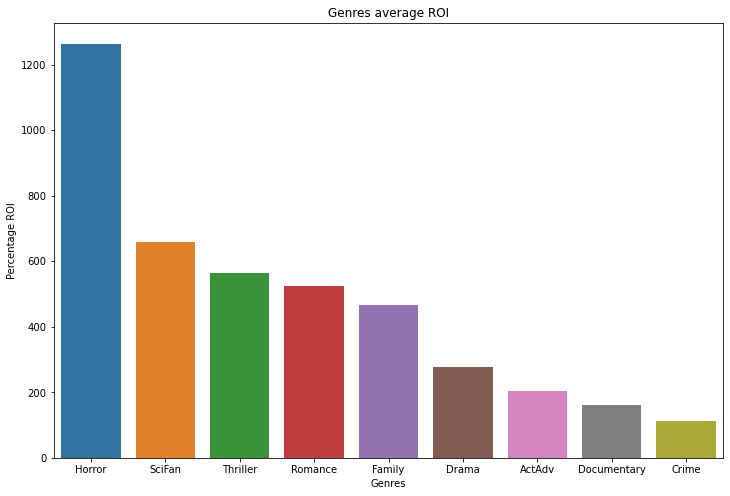

In [28]:
grouped_genre_roi_df = genre_roi_df.groupby('Assigned_genre_name').agg(
    {'ROI' : 'mean'}).sort_values(by='ROI',ascending=False)


fig,ax = plt.subplots(figsize=(12,8))

genre_roi_plot = sns.barplot(x=grouped_genre_roi_df.index,y='ROI',data=grouped_genre_roi_df)
genre_roi_plot.set_title('Genres average ROI')
genre_roi_plot.set_xlabel('Genres')
genre_roi_plot.set_ylabel('Percentage ROI');
plt.savefig('genre_roi.jpeg')



## Compare two ratings as an indicator of optimal profit 

In [29]:
# Create a new data frame called 'ratings_df'
ratings_df = genre_ratings_df[['Assigned_genre_name','averagerating','numvotes',
                              'popularity','vote_count','worldwide_gross']].copy()

In [30]:
averagerating_df = ratings_df.groupby('Assigned_genre_name').agg(
    {'averagerating' : 'median'}).sort_values(by='averagerating',ascending=False)[:10]


popularity_df = ratings_df.groupby('Assigned_genre_name').agg(
    {'popularity' : 'median'}).sort_values(by='popularity',ascending=False)[:10]

worldwide_roi_df = grouped_genre_roi_df.groupby('Assigned_genre_name').agg(
    {'ROI' : 'mean'}).sort_values(by='ROI',ascending=False)[:10]

worldwide_roi_df

,ROI
Assigned_genre_name,
Horror,1263.932961
SciFan,658.042889
Thriller,565.135670
Romance,525.303044
Family,465.706503
Drama,276.761119
ActAdv,204.044716
Documentary,162.466082
Crime,112.760203


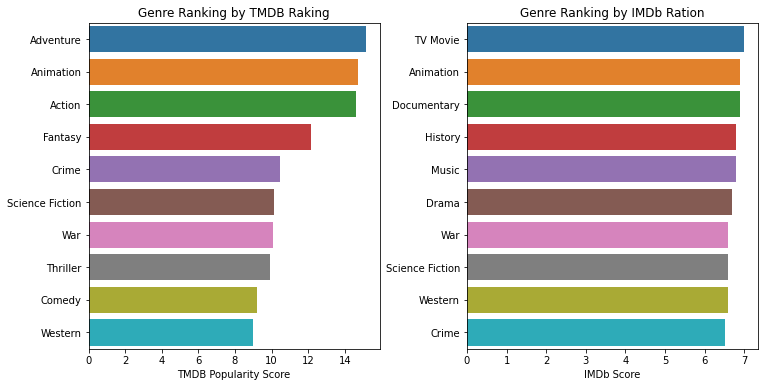

In [31]:
# Make two horizontal bar plots showing top ten based on the two ratings

fig,ax = plt.subplots(1,2,figsize=(12,6))
popularity_plot = sns.barplot(data=popularity_df, x = 'popularity',
                                             y = popularity_df.index, 
                                             ax=ax[0],orient= 'h',
                                         )
popularity_plot.set_title('Genre Ranking by TMDB Raking')
popularity_plot.set_ylabel('')
popularity_plot.set_xlabel('TMDB Popularity Score')

averagerating_plot = sns.barplot(data=averagerating_df, x = 'averagerating',
                                            y = averagerating_df.index,
                                            ax=ax[1],orient = 'h')
averagerating_plot.set_title('Genre Ranking by IMDb Ration')
averagerating_plot.set_ylabel('')
averagerating_plot.set_xlabel('IMDb Score')
fig.subplots_adjust(wspace=0.3);
plt.savefig('ratings_comparison.jpeg')


In [32]:

#fig2,ax2 = plt.subplots(figsize=(12,8))
#worldwide_gross_plot = sns.barplot(data=worldwide_gross_df, x = worldwide_gross_df[
#                                        'worldwide_gross'],y = worldwide_gross_df.index, 
#                                        orient= 'h')


### Observing differences between groups of people

As can be seen, the distribution of the coefficient of variation of box office revenue per person (more simply, risk) is virtually the same across directors, writers, and actors.


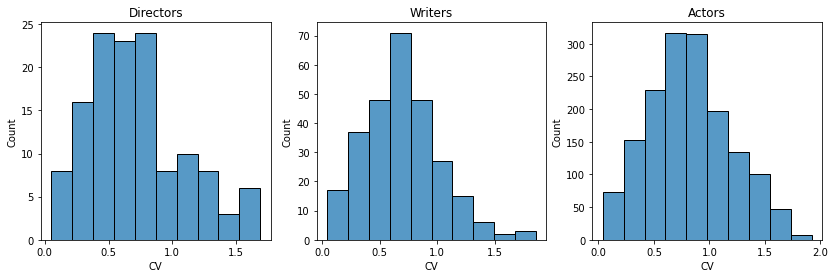

In [33]:
# How about we all use Seaborn to stay consistant with throught this notebook?
fig, ax = plt.subplots(ncols=3, figsize=(14,4))

bins = 10


directors = sns.histplot(df.loc['directors'].coefficient_of_variation,bins=bins,ax=ax[0])
directors.set_title('Directors')
directors.set_xlabel('CV')
directors.set_ylabel('Count')

writers = sns.histplot(df.loc['writers'].coefficient_of_variation, bins=bins,ax=ax[1])
writers.set_title('Writers')
writers.set_xlabel('CV')
writers.set_ylabel('Count')

actors = sns.histplot(df.loc['actors'].coefficient_of_variation, bins=bins,ax=ax[2])
actors.set_title('Actors')
actors.set_xlabel('CV')
actors.set_ylabel('Count');

In [34]:
# Modularized code into a function
def generatePeopleVisual(df, target_group, target_genre): # target_genre can be a string or a list
    # Eliminates people who are not relevant to the target genre
    spec_df = df.loc[target_group].copy()
    for row in df.loc[target_group].index:
        is_missing_genre = True
        for genre in df.loc[target_group].iloc[row].genres:
            if genre in target_genre:
                is_missing_genre = False
                break
        if(is_missing_genre):
            spec_df = spec_df.drop(row)
    spec_df = spec_df.reset_index().drop(columns=['index'])
    
    # Generates the scatter plot
    fig, ax = plt.subplots(figsize=(10,8))
    
    sns.scatterplot(x=spec_df.std_total_gross,
                    y=spec_df.mean_total_gross,
                    c=spec_df.mean_total_gross - spec_df.std_total_gross,
                    cmap='cool',
                    marker='o',
                    s=50)
    
    # Miscellaneous formatting
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=2.5)
    ax.set_xticks(np.linspace(int(round(max(spec_df.mean_total_gross), -8) / 5), int(round(max(spec_df.mean_total_gross), -8)), num=5))
    ax.ticklabel_format(style='plain')
    tick = mtick.StrMethodFormatter('${x:,.0f}')
    ax.xaxis.set_major_formatter(tick)
    ax.yaxis.set_major_formatter(tick)
    
    # Labels (accounts for list or string input)
    if(type(target_genre) == str):
        ax.set_title('Best-Performing ' + target_group.title() + ' in ' + target_genre.title() + ' Movies')
    elif(len(target_genre) == 1):
        ax.set_title('Best-Performing ' + target_group.title() + ' in ' + target_genre[0].title() + ' Movies')
    elif(len(target_genre) == 2):
        ax.set_title('Best-Performing ' + target_group.title() + ' in ' + target_genre[0].title() + \
                     ' & ' + target_genre[1].title() + ' Movies')
    else:
        ax.set_title('Best-Performing ' + target_group.title() + ' in ' + ', '.join(target_genre[0:-1]).title() + \
                    ', & ' + target_genre[-1].title() + ' Movies')
    ax.set_xlabel('S')
    ax.set_ylabel('Mean box office revenue earned')
    ax.annotate('Low risk, high reward', xy=(0.05, 0.92), xycoords='axes fraction')
    ax.annotate('High risk, low reward', xy=(0.75, 0.92), xycoords='axes fraction')  
    ax.annotate('High risk, low reward', xy=(0.75, 0.05), xycoords='axes fraction')  
    return spec_df

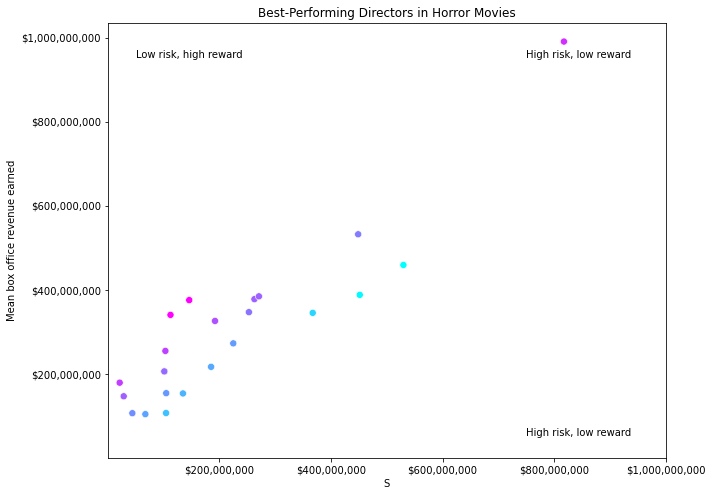

In [35]:
horr_dir_df = generatePeopleVisual(df, 'directors', 'horror')

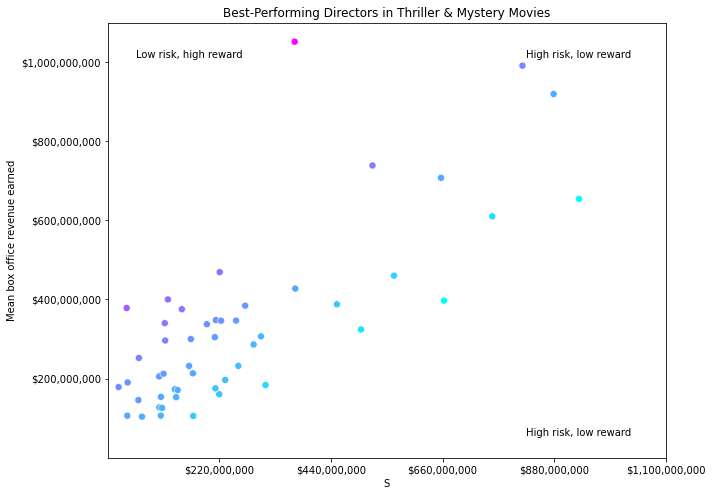

In [36]:
thrl_dir_df = generatePeopleVisual(df, 'directors', ['thriller', 'mystery'])

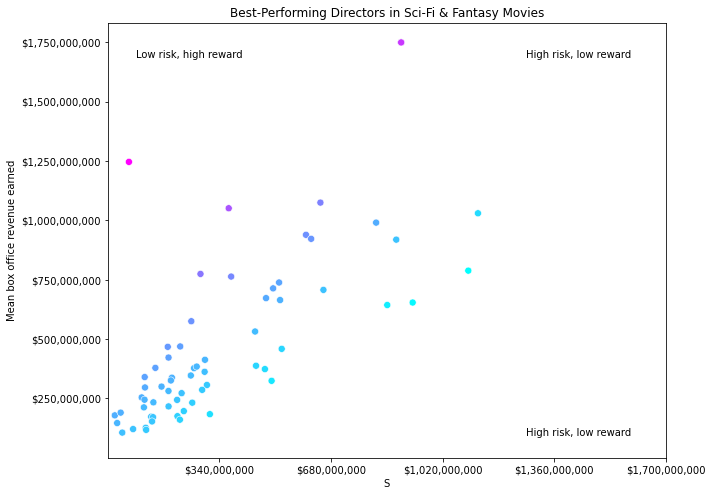

In [37]:
scif_dir_df = generatePeopleVisual(df, 'directors', ['sci-fi', 'fantasy'])

Based on the data, I make the following director recommendations to a budding studio looking to make a stand-out horror, thriller, or sci-fi/fantasy film.

In [38]:
print(horr_dir_df.iloc[2])
print('\n -=-=-=-=-=-\n')
print(horr_dir_df.iloc[3])
print('\n -=-=-=-=-=-\n')
print(horr_dir_df.iloc[14]) # A riskier, but higher-rewarding pick

primary_name                                               M. Night Shyamalan
movie_info                  [{'primary_title': 'The Last Airbender', 'genr...
num_movies                                                                  5
genres                      [drama, mystery, adventure, action, sci-fi, th...
mean_total_gross                                                  3.40167e+08
median_total_gross                                                3.56339e+08
std_total_gross                                                   1.12295e+08
coefficient_of_variation                                             0.330118
profession                                                           director
Name: 2, dtype: object

 -=-=-=-=-=-

primary_name                                                David F. Sandberg
movie_info                  [{'primary_title': 'Annabelle: Creation', 'gen...
num_movies                                                                  3
genres                    

In [39]:
print(thrl_dir_df.iloc[0])
print('\n -=-=-=-=-=-\n')
print(thrl_dir_df.iloc[6])

primary_name                                          Rawson Marshall Thurber
movie_info                  [{'primary_title': 'We're the Millers', 'genre...
num_movies                                                                  3
genres                           [adventure, action, crime, comedy, thriller]
mean_total_gross                                                  3.78461e+08
median_total_gross                                                3.72536e+08
std_total_gross                                                   3.71435e+07
coefficient_of_variation                                            0.0981436
profession                                                           director
Name: 0, dtype: object

 -=-=-=-=-=-

primary_name                                                Christopher Nolan
movie_info                  [{'primary_title': 'The Dark Knight Rises', 'g...
num_movies                                                                  4
genres                    

In [41]:
print(scif_dir_df.iloc[0])
print('\n -=-=-=-=-=-\n')
print(scif_dir_df.iloc[5])
print('\n -=-=-=-=-=-\n')
print(scif_dir_df.iloc[6])

primary_name                                                    Peter Jackson
movie_info                  [{'primary_title': 'The Hobbit: The Battle of ...
num_movies                                                                  3
genres                                           [fantasy, family, adventure]
mean_total_gross                                                  1.24648e+09
median_total_gross                                                1.21873e+09
std_total_gross                                                   6.43123e+07
coefficient_of_variation                                            0.0515952
profession                                                           director
Name: 0, dtype: object

 -=-=-=-=-=-

primary_name                                                Christopher Nolan
movie_info                  [{'primary_title': 'The Dark Knight Rises', 'g...
num_movies                                                                  4
genres                    